<a href="https://colab.research.google.com/github/SydanJainen/Cell-image-segmentation/blob/main/image_Segmantation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CELL IMAGE SEGMENTATION

## HYPERPARAMETER


In [1]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNEL = 3

BATCH_SIZE = 8
EPOCHS = 6
PADDING = 0
STRIDE = 2
PATIENCE = 2

VAL_SPLIT = 0.30
SEED = 42

LEARNING_RATE = 1e-4
EPS = 1e-7
CHECKPOINT_PATH = 'unet_chckpnt.pth.tar'

width_out = 256
height_out = 256

STEP_AUGMENTATION = 5

## CHECK IF COLAB OR OFFLINE

In [2]:
if 'google.colab' in str(get_ipython()):
  isColab = True
else:
  isColab = False

## CHECK IF GPU IS AVAILABLE

In [3]:
import torch

num_gpu = torch.cuda.device_count()
print(f'{num_gpu} GPU available')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

1 GPU available


## REQUIREMENT

In [4]:
if isColab:
  import os
  from google.colab import files, drive
  if (not 'kaggle.json' in os.listdir()):
    print("Upload kaggle.json")
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
  drive.mount('/content/drive')
  DB_PATH = '/content/drive/MyDrive/scuola/deeplife/'
else:
  print("Check if folder is correct")
  DB_PATH = 'database/'

Check if folder is correct


## IMPORTS

In [5]:
if isColab:
    !pip install opencv-python
    !pip install tqdm

In [6]:
import os
import sys
import glob
import tqdm
import json
import gc
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cv2
from cv2 import imwrite
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as F
from sklearn.model_selection import train_test_split
import albumentations as A

In [7]:
# aplly SEED to all random functions
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

#create a fodler with the hyperparameters name to save the results
if not os.path.exists(f'results'):
    os.makedirs(f'results')
if not os.path.exists(f'results/{EPOCHS}epochs_{BATCH_SIZE}batch_{LEARNING_RATE}lr_{PATIENCE}patience_{EPS}eps_STEPAUG{STEP_AUGMENTATION}'):
    os.makedirs(f'results/{EPOCHS}epochs_{BATCH_SIZE}batch_{LEARNING_RATE}lr_{PATIENCE}patience_{EPS}eps_STEPAUG{STEP_AUGMENTATION}')
RESULTS_PATH = f'results/{EPOCHS}epochs_{BATCH_SIZE}batch_{LEARNING_RATE}lr_{PATIENCE}patience_{EPS}eps_STEPAUG{STEP_AUGMENTATION}/'

In [8]:
if os.path.exists(DB_PATH):
    print("Database folder found")
else:
    print(" Generate the database")
    os.makedirs(DB_PATH)
    os.chdir(DB_PATH)
    if(isColab):
        !pip install kaggle
        !kaggle competitions download -c data-science-bowl-2018
        !unzip -q data-science-bowl-2018.zip -d ./
        !unzip -q cellular-segmentation/stage1_train.zip -d unpreocessed/
        if os.path.exists('./cellular-segmentation') and os.path.exists('./data-science-bowl-2018.zip'):
            !rm data-science-bowl-2018.zip
    else:
        print("Download the database and place it in the folder")
    os.chdir('..')

Database folder found


In [9]:
IMAGE_PATH = os.path.join(DB_PATH, "train")
LABEL_PATH = os.path.join(DB_PATH, "label")

AUG_IMAGE_PATH = os.path.join(DB_PATH, "augmented/train")
AUG_LABEL_PATH = os.path.join(DB_PATH, "augmented/label")

# Ensure both directories have the same number of files
number_images = len(os.listdir(IMAGE_PATH))
number_labels = len(os.listdir(LABEL_PATH))

number_augmented_images = len(os.listdir(AUG_IMAGE_PATH))
number_augmented_labels = len(os.listdir(AUG_LABEL_PATH))

assert number_images == number_labels
assert number_augmented_images == number_augmented_labels

# LOAD PIL IMAGES AND LABELS
image_files = sorted(os.listdir(IMAGE_PATH))
label_files = sorted(os.listdir(LABEL_PATH))

aug_image_files = sorted(os.listdir(AUG_IMAGE_PATH))
aug_label_files = sorted(os.listdir(AUG_LABEL_PATH))

# Split into train and temp sets
train_images, val_images, train_labels, val_labels = train_test_split(image_files, label_files, test_size=VAL_SPLIT, random_state=SEED)
train_aug_images, val_aug_images, train_aug_labels, val_aug_labels = train_test_split(aug_image_files, aug_label_files, test_size=VAL_SPLIT, random_state=SEED)


In [10]:
# Get and resize train images and masks
x_train = np.zeros((number_images, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)
y_train = np.zeros((number_labels, height_out, width_out, 1))
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for length in tqdm.tqdm(range(number_images)):
    img = cv2.imread(IMAGE_PATH + '/' + image_files[length])
    x_train[length] = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)

    mask = cv2.imread(LABEL_PATH + '/' + label_files[length], cv2.IMREAD_GRAYSCALE)
    y_train[length] = cv2.resize(mask, (width_out, height_out), interpolation=cv2.INTER_AREA).reshape(height_out, width_out, 1)

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [00:01<00:00, 591.55it/s]

Done!


In [11]:
x_train_aug = np.zeros((number_augmented_images, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)
y_train_aug = np.zeros((number_augmented_labels, height_out, width_out, 1))
for length in tqdm.tqdm(range(number_augmented_images)):
    img = cv2.imread(AUG_IMAGE_PATH + '/' + aug_image_files[length])
    x_train_aug[length] = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)

    mask = cv2.imread(AUG_LABEL_PATH + '/' + aug_label_files[length], cv2.IMREAD_GRAYSCALE)
    y_train_aug[length] = cv2.resize(mask, (width_out, height_out), interpolation=cv2.INTER_AREA).reshape(height_out, width_out, 1)
print('Done!')

100%|██████████| 3350/3350 [00:08<00:00, 408.75it/s]

Done!


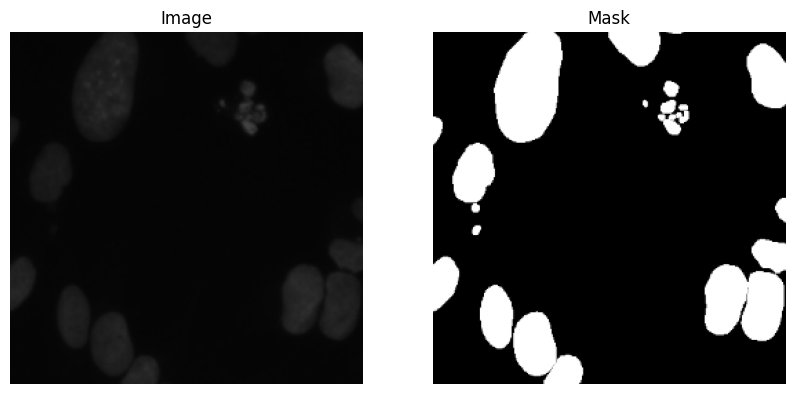

In [12]:
# draw random sample from the dataset

def draw_sample(x, y):
    idx = random.randint(0, len(x)-1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(x[idx])
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(y[idx].squeeze(), cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')
    plt.show()

draw_sample(x_train, y_train)

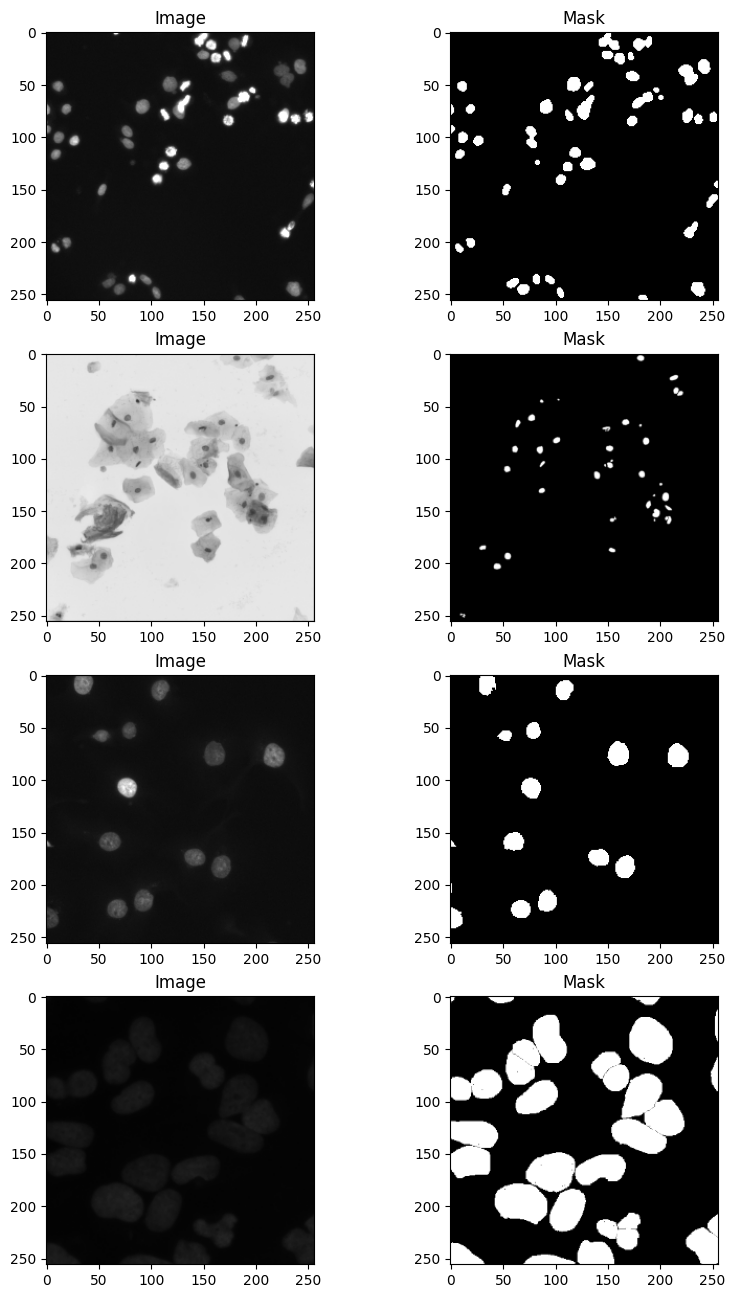

In [13]:
#no
plt.figure(figsize=(20, 16))

# take random 4 images
x, y = 4, 4
for i in range(y):
    index = random.randint(0, len(x_train))
    plt.subplot(y, x, i * x + 1)
    plt.imshow(x_train[index])
    plt.title('Image')

    plt.subplot(y, x, i * x + 2)
    plt.imshow(y_train[index].squeeze(), cmap='gray')
    plt.title('Mask')

## DATASET

In [14]:
import numpy as np
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

class Nuc_Seg(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.float32)) # np.int32
        
        #image = TF.pad(image, padding = 0, padding_mode = 'reflect')
        #mask = TF.pad(mask, padding = 0, padding_mode = 'reflect')
        
        angle = random.uniform(-10, 10)
        width, height = image.size
        max_dx = 0.1 * width
        max_dy = 0.1 * height
        translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
        scale = random.uniform(0.8, 1.2)
        shear = random.uniform(-0.5, 0.5)
        #image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
        #mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
        
        image = TF.resize(image, (256, 256))
        mask = TF.resize(mask, (256, 256))
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
        
    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return image, mask    

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = SEED)
X_train_aug, X_val_aug, Y_train_aug, Y_val_aug = train_test_split(x_train_aug, y_train_aug, test_size = 0.1, random_state = SEED)

X_train = np.concatenate((X_train, X_train_aug), axis = 0)
Y_train = np.concatenate((Y_train, Y_train_aug), axis = 0)
X_val = np.concatenate((X_val, X_val_aug), axis = 0)
Y_val = np.concatenate((Y_val, Y_val_aug), axis = 0)

train_dataset = Nuc_Seg(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataset = Nuc_Seg(X_val, Y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)




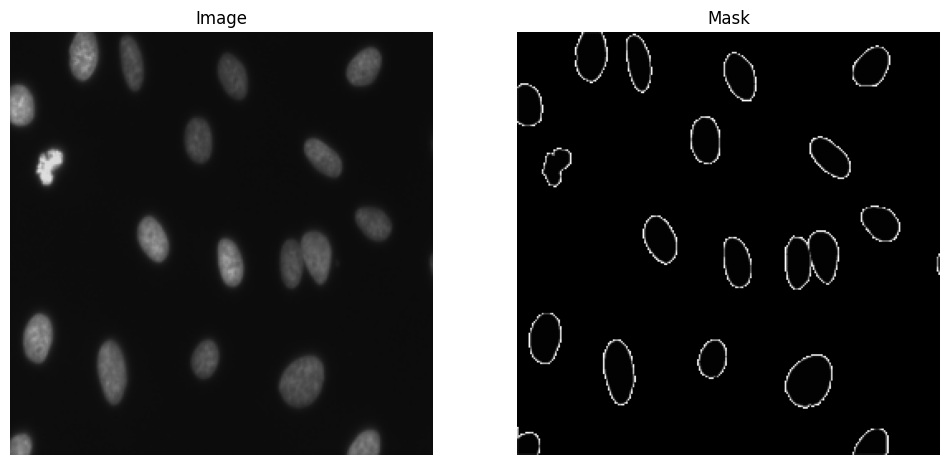

In [16]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def plot_sample(dataset, idx):
    """
    Plots a sample from the dataset.
    
    Args:
        dataset (Dataset): The dataset from which to plot a sample.
        idx (int): The index of the sample to plot.
    """
    image, mask = dataset[idx]

    # Convert tensors to PIL images for plotting
    image = TF.to_pil_image(image)
    mask = TF.to_pil_image(mask)

    # Plot the image and mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

plot_sample(train_dataset, idx=0)



## MODEL

In [17]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNETV1(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNETV1, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)

In [18]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


METRICS

## Jaccard Index: Measuring Intersection Over Union (IoU)

The **Jaccard Index** is a metric used to compare the similarity between two sets. It calculates the ratio of the size of the intersection of the sets to the size of their union. Mathematically, it's defined as:

$$
J(A, B) = |A ∩ B| / |A ∪ B|
$$

## Jaccard Loss 

The **Jaccard Loss** is derived from the Jaccard index and serves as a loss function during model training. This loss function is particularly useful for image segmentation tasks where the goal is to optimize the model for accurate segmentation. It's defined as:

$$
\mathcal{L}_{\text{Jaccard}}(\mathbf{p}, \mathbf{t}) = 1 - J(\mathbf{p}, \mathbf{t})
$$

where $J(\mathbf{p}, \mathbf{t})$ is the Jaccard index computed between the predicted and true values.


In [19]:
def jaccard(preds, trues, is_average=True):
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)

    intersection = (preds * trues).sum(1)
    scores = (intersection + EPS) / ((preds + trues).sum(1) - intersection + EPS)

    score = scores.sum()
    if is_average:
        score /= num
    return torch.clamp(score, 0., 1.)

def jaccard_round(preds, trues, is_average=True):
    preds = torch.round(preds)
    return jaccard(preds, trues, is_average=is_average)


class JaccardLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average

    def forward(self, input, target):
        return jaccard(input, target, self.size_average)
    
def iou_metric(y_pred, y_true):
    """
    Calcola la metrica di Accuracy basata su IoU.

    Args:
        y_pred (torch.Tensor): Le predizioni del modello.
        y_true (torch.Tensor): Le ground truth.

    Returns:
        torch.Tensor: La metrica di Accuracy basata su IoU.
    """

    # Convertirsi in binario
    y_pred_bin = y_pred > 0.5
    y_true_bin = y_true > 0.5

    # Calcolare l'intersezione
    intersection = (y_pred_bin & y_true_bin).sum()

    # Calcolare l'unione
    union = (y_pred_bin | y_true_bin).sum()

    # Calcolare l'IoU
    iou = (intersection + EPS) / (union + EPS)

    # Calcolare l'Accuracy
    accuracy = iou.mean()

    return accuracy

## Dice Loss

The Dice Loss is a metric used to evaluate the performance of models in tasks like image segmentation. It focuses on the overlap between the predicted segmentation mask and the ground truth mask, penalizing models that incorrectly classify pixels.

A: Predicted segmentation mask pixels

B: Ground truth segmentation mask pixels

$$
L_Dice(A, B) = 1 - 2 * |A ∩ B| / (|A| + |B|)
$$

In [20]:
def dice_loss(preds, trues, weight=None, is_average=True):
    preds = preds.contiguous().view(preds.size(0), -1)
    trues = trues.contiguous().view(trues.size(0), -1)
        
    intersection = (preds * trues).sum(1)
    scores = (2. * intersection + EPS) / (preds.sum(1) + trues.sum(1) + EPS)
    
    if is_average:
        return scores.mean()
    else:
        return scores

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)

    def forward(self, input, target):
        # Applica sigmoid per normalizzare l'output
        input = torch.sigmoid(input)
        # Clamp per evitare valori estremi
        # input = torch.clamp(input, EPS, 1 - EPS)
        return dice_loss(input, target, self.weight, self.size_average)

In [21]:
class BitWiseMetrics(nn.Module):
    def __init__(self, threshold=0.5):
        super().__init__()
        self.threshold = threshold

    def forward(self, input, target):
        return bitwise_metric(input, target, self.threshold)

def bitwise_metric(preds, trues, threshold=0.5):
    preds = (preds > threshold).float()
    return (preds == trues).sum()

TRAIN 1

In [22]:
def fit(model, epochs, opt, criterion, train_loader, val_loader, accuracy_metric = iou_metric, device='cuda', patience=PATIENCE, min_delta=1e-4):
    train_losses = []
    val_losses = []
    total_train_score = []
    total_valid_score = []
    best_val_loss = float('inf')
    best_model_wts = None
    early_stop_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_score = 0.0

        for image, mask in train_loader:
            image, mask = image.to(device), mask.to(device)

            opt.zero_grad()
            out = model(image)

            out = nn.functional.sigmoid(out)

            loss = criterion(out, mask)
            loss.backward()
            opt.step()

            train_loss += loss.item()
            t_score = accuracy_metric(out,mask)
            train_score += t_score.item()

        avg_train_score = train_score / len(train_loader) * 100
        avg_train_loss = train_loss / len(train_loader) * 100

        total_train_score.append(avg_train_score)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        valid_score = 0.0

        with torch.no_grad():
            for image, mask in val_loader:
                image, mask = image.to(device), mask.to(device)
                out = model(image)

                out = nn.functional.sigmoid(out)

                loss = criterion(out, mask)
                val_loss += loss.item()
                score = accuracy_metric(out,mask)
                valid_score += score.item()
                
        avg_val_score = valid_score / len(val_loader) * 100
        avg_val_loss = val_loss / len(val_loader) * 100

        val_losses.append(avg_val_loss)
        total_valid_score.append(avg_val_score)

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")
        print(f"Train Score: {avg_train_score:.6f}, Valid Score: {avg_val_score:.6f}")
        
        # Early stopping check for plateau
        if best_val_loss - avg_val_loss > min_delta:
            best_val_loss = avg_val_loss
            best_model_wts = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping due to plateau or overfitting")
            break

    # Load the best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return train_losses, val_losses, total_train_score, total_valid_score

In [23]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [24]:
model = UNET(in_channels=3, out_channels=1).to(device)
model.apply(weights_init)
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

t_losses, v_losses, t_scores, v_scores = fit(model, EPOCHS, optimizer, criterion, train_loader, val_loader)


Epoch 1/6, Training Loss: 1.925737, Validation Loss: 2.018682
Train Score: 0.066590, Valid Score: 0.036185
Epoch 2/6, Training Loss: 1.859429, Validation Loss: 1.982778
Train Score: 0.064380, Valid Score: 0.057108
Epoch 3/6, Training Loss: 1.835398, Validation Loss: 1.983237
Train Score: 0.060497, Valid Score: 0.035981
Epoch 4/6, Training Loss: 1.821270, Validation Loss: 1.962829
Train Score: 0.058514, Valid Score: 0.030393
Epoch 5/6, Training Loss: 1.818225, Validation Loss: 1.974602
Train Score: 0.059494, Valid Score: 0.027718
Epoch 6/6, Training Loss: 1.822989, Validation Loss: 1.953900
Train Score: 0.057246, Valid Score: 0.040907


In [25]:
# Training Loss
plt.figure()
plt.semilogy(t_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.savefig(f'{RESULTS_PATH}training_loss.png')
plt.close()

# Validation Loss
plt.figure()
plt.semilogy(v_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.savefig(f'{RESULTS_PATH}validation_loss.png')
plt.close()

# Training Score
plt.figure()
plt.semilogy(t_scores, label='Training Score')
plt.title('Training Score')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.savefig(f'{RESULTS_PATH}training_score.png')
plt.close()

# Validation Score
plt.figure()
plt.semilogy(v_scores, label='Validation Score')
plt.title('Validation Score')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.savefig(f'{RESULTS_PATH}validation_score.png')
plt.close()

# Training Loss (linear scale)
plt.figure()
plt.plot(t_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{RESULTS_PATH}training_loss_linear.png')
plt.close()

# Validation Loss (linear scale)
plt.figure()
plt.plot(v_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{RESULTS_PATH}validation_loss_linear.png')
plt.close()


1e61ecf354cb93a62a9561db87a53985fb54e001444f98112ed0fc623fad793e.png


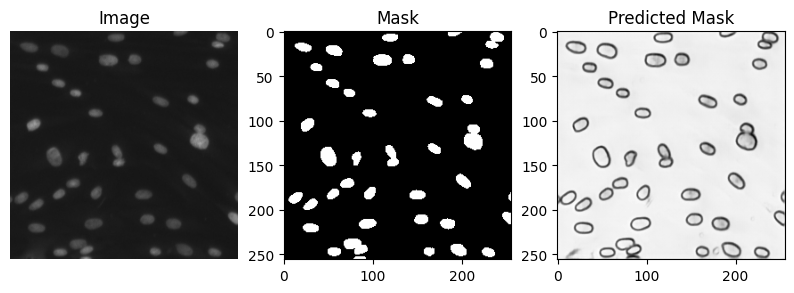

In [26]:
def predict(model, image):
    model.eval()
    image = image.to(device)
    out = model(image.float())
    #out = nn.functional.sigmoid(out)
    return out

index = random.randint(0, len(val_dataset)- 1)
image, mask = val_dataset[index]

print(val_images[10])
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)

# predict the mask
predicted_mask = predict(model, image)

# plot the image, mask and predicted mask
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.title("Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Mask")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze().cpu().detach().numpy(), cmap="gray")
plt.title("Predicted Mask")

plt.show()

In [27]:
def save_checkpoint(state, filename="unet_chckpnt.pth.tar"):
    torch.save(state, RESULTS_PATH + filename)

def load_ckp(checkpoint_fpath, model, optimizer):

    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint

In [28]:
save_checkpoint(model)

In [29]:
def invert_colors(image):
    return 1 - image


def enhance_brightness(image, factor=1.2):

    bright_mask = image > 0.5

    enhanced_image = image.clone()
    enhanced_image[bright_mask] = torch.clamp(image[bright_mask] * factor, 0, 1)
    return enhanced_image

In [30]:
#TEST
DB_PATH_TEST = os.path.join(DB_PATH, "test/")

set_image = np.zeros((len(DB_PATH_TEST), 128, 128, 3), dtype = np.uint8)

img_height = 256
img_width = 256
img_channel = 3

def preprocess(id_, path = DB_PATH_TEST, img_height = 256, img_width = 256, img_channel = 3):
    
    # initialize two empty array to store
    # size is (# of training instance, img_size, img_size, img_channel)
    set_image = np.zeros((len(id_), img_height, img_width, img_channel), dtype = np.uint8)
    
    # iterate through all the training img, save each training instance into X_train
    # using tqdm is good for us to visualize the process
    for n, id_ in tqdm.tqdm(enumerate(id_), total = len(id_)):   
        cur_path = path + id_
        # read in img as array
        img = imread(cur_path + '/images/' + id_ + '.png')[:,:,:img_channel]  
        # resize data to increase the speed of training
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        # save current img into X_train
        set_image[n] = img  
        # for each img, we have several masks
        # we need to iterate through each one 
        
    return set_image

X_Test = preprocess(os.listdir(DB_PATH_TEST))
len(X_Test)

100%|██████████| 65/65 [00:02<00:00, 24.26it/s]


65

In [31]:
def predict(model, image):
    model.eval()
    image = image.to(device)
    out = model(image.float())
    #out = (out - out.min()) / (out.max() - out.min())
    out = nn.functional.sigmoid(out)
    return out

TEST_PATH = RESULTS_PATH  + "test/"

if not os.path.exists(TEST_PATH):
    os.makedirs(TEST_PATH)


for index in range(0, len(X_Test)):
    image = X_Test[index]
    image = TF.to_tensor(image)
    image = image.unsqueeze(0)
    predicted_mask = predict(model, image)
    enhanced_predicted_mask = enhance_brightness(predicted_mask)
    inverted_predicted_mask = invert_colors(enhanced_predicted_mask)
    final_mask = (inverted_predicted_mask > 0.5).float()


    plt.figure(figsize=(20, 4))

    # Plot the original image
    plt.subplot(1, 4, 1)
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().detach().numpy())
    plt.title("Image")
    plt.axis("off")

    # Plot the predicted mask
    plt.subplot(1, 4, 2)
    plt.imshow(predicted_mask.squeeze().cpu().detach().numpy(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    # Plot the inverted enhanced predicted mask
    plt.subplot(1, 4, 3)
    plt.imshow(inverted_predicted_mask.squeeze().cpu().detach().numpy(), cmap="gray")
    plt.title("Inverted Predicted Mask")
    plt.axis("off")

    # Plot the enhanced predicted mask
    plt.subplot(1, 4, 4)
    plt.imshow(final_mask.squeeze().cpu().detach().numpy(), cmap="gray")
    plt.title("Final Predicted Mask")
    plt.axis("off")

    # Save the figure
    plt.savefig(f'{TEST_PATH}{index}_test_comparison.png')
    plt.close()